# Forecasting Competition

### Background and Tasks

A few years ago I participated in a conference where beach shoreline modellers from around the world competed to make accurate predictions of a particular beach shoreline time series (similar to the one we've been seeing in lectures throughout this course). Participants were given a 15 year time series (1999 - 2013, inclusive) of *daily* data of the shoreline location in meters from a datum (just think of it as the width of the beach) of Tairua Beach in New Zealand, and were tasked with predicting the *monthly* shoreline location for the next 3 years (2014 - 2016, inclusive).

Your tasks in this lab are simple:
1. Predict the monthly beach shoreline location over the test period (Jan 2014 - Dec 2016, inclusive: that's 36 months) and export your predictions into the csv `data/beach-test.csv` I've included with your lab (read more details about that in the next section); and,
2. Make a plot of the training data and your predictions using any plotting library you wish (I want you to get into the habit of always plotting your predictions, the insight you can get from a visual examination of your predictions is priceless).

### Data and Submission

I have provided you with several relevant data files in the `data/` folder:

- `beach-train.csv`: 15 years of *daily* shoreline data.
- `beach-test.csv`: template you should use to make *monthly* shoreline predictions for Jan 2014 - Dec 2016.
- `waves-train.csv` (optional): file of monthly wave height and wave period you may wish to use as explanatory variables.
- `waves-test.csv` (optional): monthly wave height and wave period over the test period.

You should make your predictions using the `beach-test.csv` template provided to you in your repo. **Be sure to push this .csv file to GitHub so I can evaluate it**. You should also submit a HTML-render of your assignment to Canvas as-per-usual (following the usual instructions at the end of the lab assignment) so we can look at your code and plot (you do not need to submit your .csv predictions to Canvas).

### Evaluation

Following in the footsteps of the [M4 time series competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), submissions will be evaluated based on the average of two metrics:
1. Symmetric mean absolute percentage error (sMAPE)

$$\text{sMAPE}=\frac{2}{h}\sum_{t=n+1}^{n+h}\frac{|y_t-\hat{y_t}|}{|y_t|+|\hat{y_t}|}*100(\%)$$

2. Mean absolute scaled error (MASE)

$$\text{MASE}=\frac{1}{h}\frac{\sum_{t=n+1}^{n+h}|y_t-\hat{y_t}|}{\frac{1}{n-1}\sum_{t=2}^{n}|y_t-y_{t-1}|}$$

Where $y_t$ is the value of the series at time $t$, $\hat{y_t}$ is the forecast at time $t$, $h$ is the forecast horizon, $n$ is the number of training samples.

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from canvasutils.submit import submit, convert_notebook
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import plotly.express as px
from statsmodels.tsa.api import ETSModel, SimpleExpSmoothing, seasonal_decompose

In [3]:
# load data
train_df = pd.read_csv('data/beach-train.csv', parse_dates=True, index_col='Time').resample("1M").mean().interpolate(method="linear")
test_df = pd.read_csv('data/beach-test.csv', parse_dates=True, index_col='Time')  
train_df.index.freq = "M"
test_df.index.freq = "M"
train_df.head()

Shoreline
Time                 
1999-01-31  57.509911
1999-02-28  56.589458
1999-03-31  57.779581
1999-04-30  59.224900
1999-05-31  62.658231

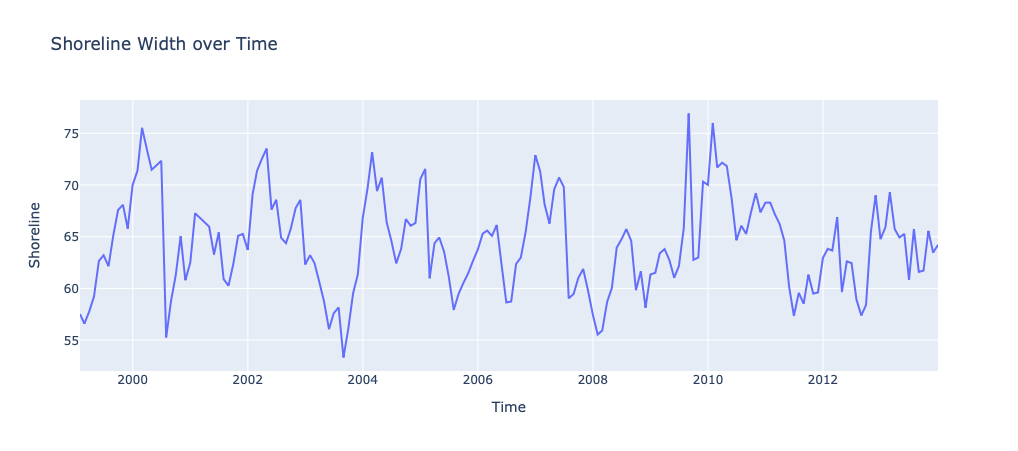

In [4]:
px.line(train_df, y="Shoreline", title="Shoreline Width over Time")

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

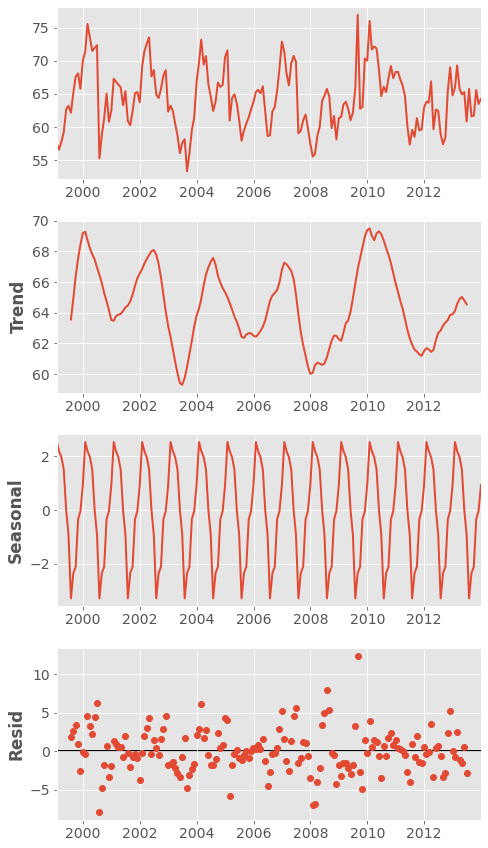

In [6]:
# decomposition of series

model = seasonal_decompose(train_df[["Shoreline"]], model="additive", period=12)
with mpl.rc_context():  
    mpl.rc("figure", figsize=(7, 12))
    model.plot()
    plt.tight_layout()

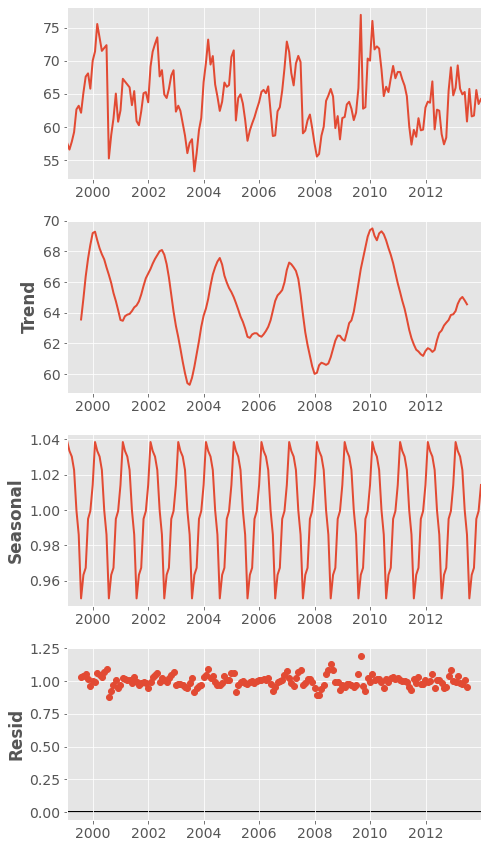

In [7]:
model = seasonal_decompose(train_df[["Shoreline"]], model="multplicative", period=12)
with mpl.rc_context():  
    mpl.rc("figure", figsize=(7, 12))
    model.plot()
    plt.tight_layout()

> Based on visualization of the full series, it seems there is some seasonality in the data, though perhaps not varying over time. I would suggest this model is likely additive. Based on the decomposition of the time series, it appears the model is very unlikely multiplicative. The residual component is centered around 1, unlike the result seen with the additive model decomposition where the residuals were concentrated around 0.

### Split Data - use Validation set to train models

In [8]:
df_train, df_valid = train_test_split(train_df.dropna(), test_size=0.2, shuffle=False)
df_train = df_train.assign(Label="Train")
df_valid = df_valid.assign(Label="Valid")

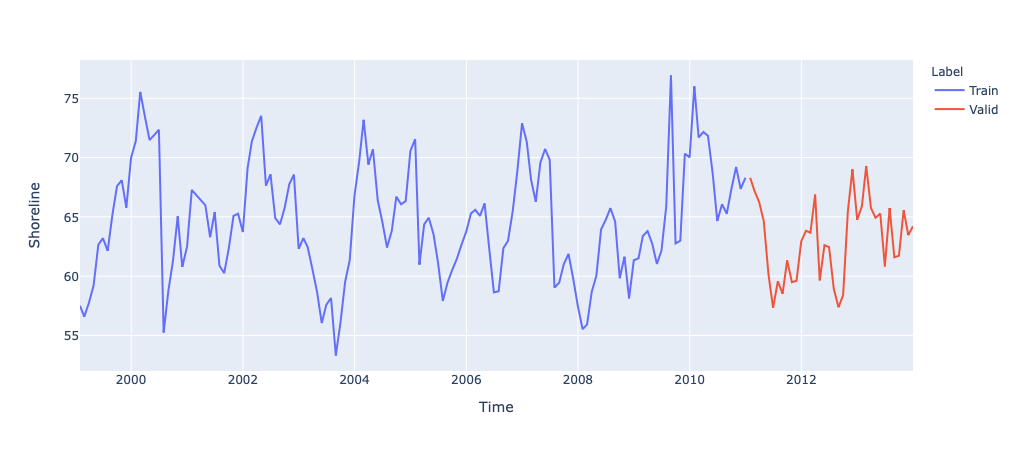

In [9]:
px.line(pd.concat((df_train, df_valid)), y="Shoreline", color="Label")

### Initial Models

In [10]:
forecast_index = test_df.index

In [11]:
forecast_index_2 = df_valid.index

#### Naive Forecasts

In [12]:
naive = pd.DataFrame({"Shoreline":df_train["Shoreline"].iloc[-1],
                      "Label":"Naive"}, 
                     index=forecast_index_2)

#### ETS Forescasts

In [13]:
ets = ETSModel(df_train['Shoreline'], error="add", trend="add", seasonal="add").fit()

ets_aaa = pd.DataFrame({"Shoreline": ets.forecast(len(df_valid)),
                      "Label": "ETS(AAA)"},
                     index=forecast_index_2)

In [14]:
model = ETSModel(df_train["Shoreline"], error="add", trend="add", seasonal="mul", seasonal_periods=12).fit()
ets_aam = pd.DataFrame({"Shoreline": model.forecast(len(forecast_index_2)),
                        "Label": "ETS (AAM)"},
                       index=forecast_index_2)

#### ARIMA Forecasts

In [15]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

# adapted from Tom's code 
best_model = {"aic": np.inf}
for p, d, q, P, D, Q in product(range(3), range(2), range(2), range(3), range(2), range(2)):
    tentative_model = ARIMA(train_df, order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit()
    if tentative_model.aic < best_model['aic']:
        best_model['aic'] = tentative_model.aic
        best_model['order'] = (p, d, q)
        best_model['seasonal_order'] = (P, D, Q)

/Users/larahabashy/Downloads/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/larahabashy/Downloads/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [16]:
print(best_model)

{'aic': 898.4958457661863, 'order': (2, 0, 1), 'seasonal_order': (0, 1, 1)}


In [17]:
model_arima = ARIMA(df_train["Shoreline"], order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)).fit()

sarima_df = pd.DataFrame({"Shoreline": model_arima.forecast(len(df_valid)),
                         "Label": "SARIMA"},
                        index=forecast_index_2)

/Users/larahabashy/Downloads/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/larahabashy/Downloads/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/larahabashy/Downloads/miniconda3/envs/mds574/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [18]:
arima_residuals = model_arima.resid

> At this point, I decided to fit a GARCH model on the residuals of the ARIMA model. A GARCH(1, 1) has the lowest AIC value out of other permutations of (1,2). 

In [19]:
from arch import arch_model

garch = arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7260.450430638153
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1125311770.8699212
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5419.1532655417095
Iteration:      4,   Func. Count:     24,   Neg. LLF: 893.354423467033
Iteration:      5,   Func. Count:     30,   Neg. LLF: 522.7731489840603
Iteration:      6,   Func. Count:     36,   Neg. LLF: 436.1846856726761
Iteration:      7,   Func. Count:     42,   Neg. LLF: 515.2142115470831
Iteration:      8,   Func. Count:     48,   Neg. LLF: 424.80139358541976
Iteration:      9,   Func. Count:     54,   Neg. LLF: 423.60361242793965
Iteration:     10,   Func. Count:     59,   Neg. LLF: 423.59265447946564
Iteration:     11,   Func. Count:     64,   Neg. LLF: 423.5868003787757
Iteration:     12,   Func. Count:     69,   Neg. LLF: 423.5858058019917
Iteration:     13,   Func. Count:     74,   Neg. LLF: 423.5858042153057
Iteration:     14,   Func. Count:     78,   Neg. LLF: 423.58

In [20]:
# print(garch_fitted.summary())

In [21]:
garch_forecast = garch_fitted.forecast(horizon=len(df_valid), reindex=True)

In [22]:
garch_mean = garch_forecast.mean.iloc[-1]
garch_var = garch_forecast.residual_variance.iloc[-1]

In [23]:
# conditional mean
garch_m_df = pd.DataFrame({"GARCH Forescasts Mean": np.array(garch_forecast.mean.iloc[-1])},
                        index=forecast_index_2)
garch_m_df['Shoreline'] = sarima_df['Shoreline'] - garch_m_df['GARCH Forescasts Mean']
garch_m_df['Label'] = 'ARCH-adjusted SARIMA'
garch_m_df = garch_m_df.drop(columns=['GARCH Forescasts Mean'])

In [24]:
# conditional variance
garch_v_df = pd.DataFrame({"GARCH Forescasts Variance": np.array(garch_forecast.variance.iloc[-1])},
                        index=forecast_index_2)

garch_v_df['Shoreline'] = sarima_df['Shoreline'] - np.sqrt(garch_v_df['GARCH Forescasts Variance'])
garch_v_df['Label'] = 'GARCH-adjusted SARIMA'
garch_v_df = garch_v_df.drop(columns=["GARCH Forescasts Variance"])

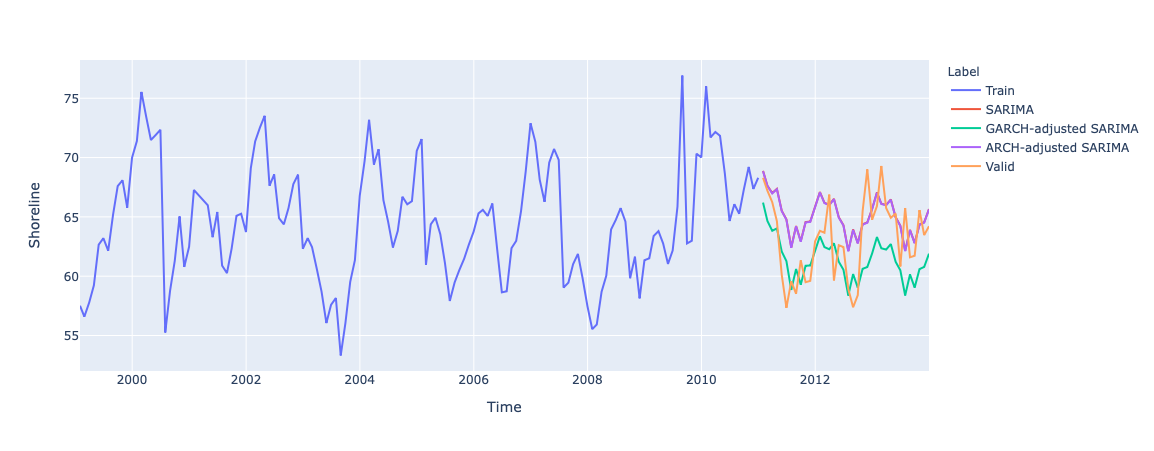

In [25]:
# Plot all sarima variants forecasts
import plotly.express as px
px.line(pd.concat((df_train[["Shoreline", "Label"]], sarima_df, garch_v_df, garch_m_df, df_valid)),
        y="Shoreline",
        color="Label")

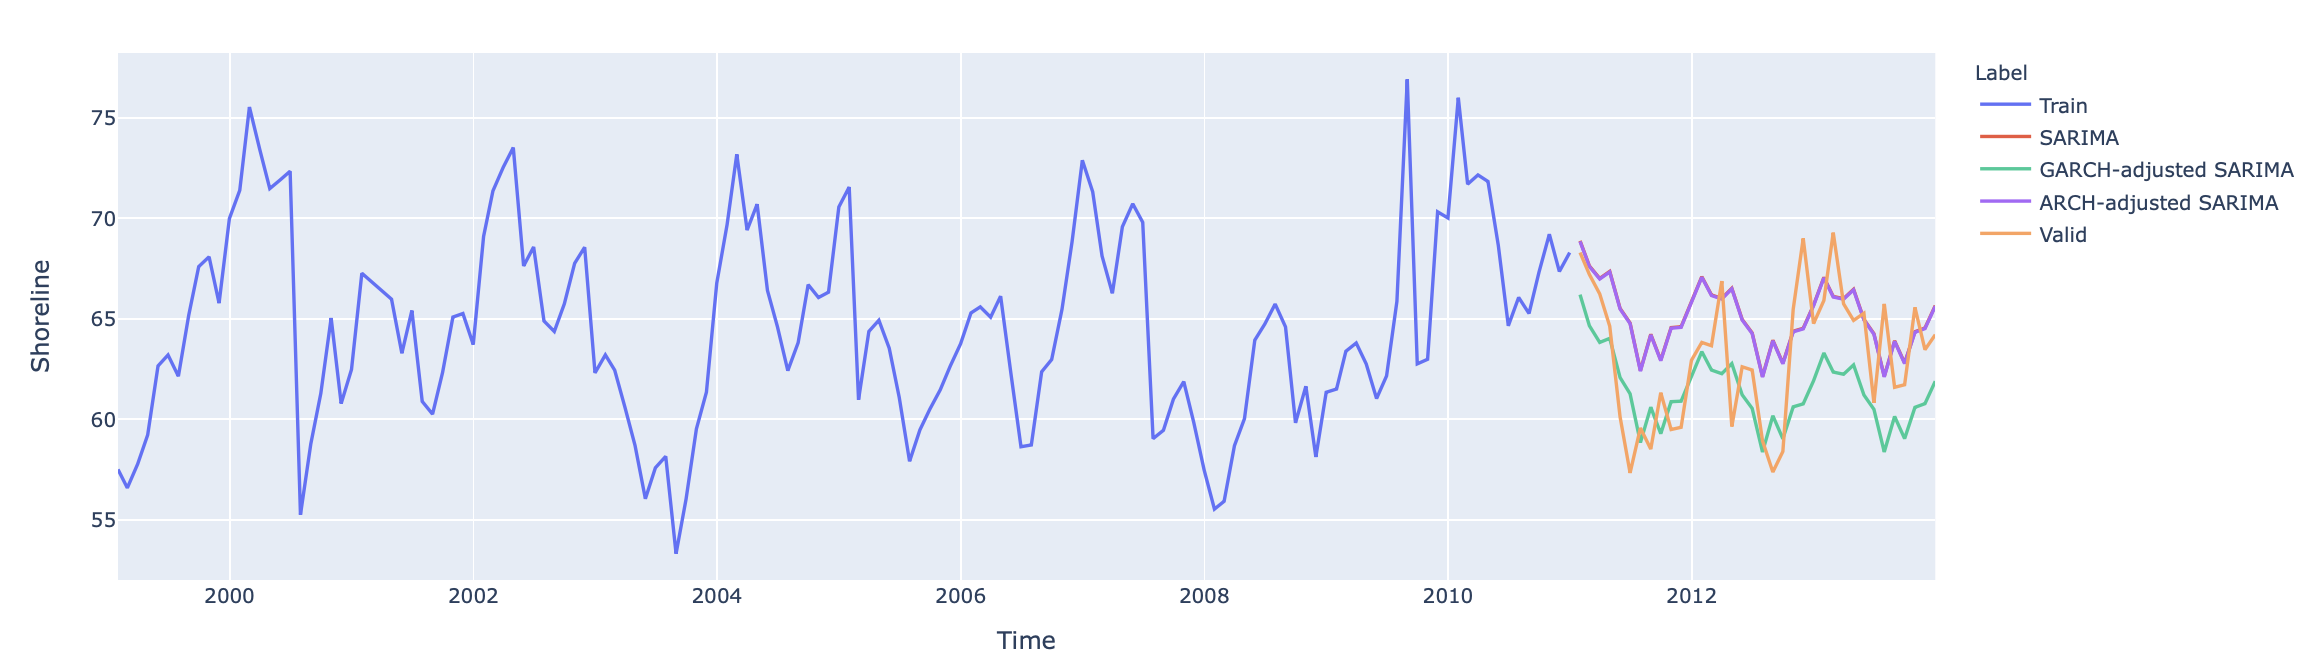

In [26]:
from IPython.display import Image
Image(filename='img/srma_fx.png')

#### ML Approach - A Random Forest Regressor

In [27]:
# code adapted from lecture 4 notes

def lag_df(df, lag=1, cols=None):
    """Add lagged columns to dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to add lagged columns to.
    lag : int, optional
        How many lagged values to add. By default = 1.
    cols : list, optional
        Columns to lag. By default all columns in df.

    Returns
    -------
    pd.DataFrame
        DataFrame appended with lagged columns.

    Examples
    --------
    >>> pd.DataFrame({'col': [1, 2]})
    >>> lag_df(df, 3)
       col  col-1  col-2  col-3
    0    1    NaN    NaN    NaN
    1    2    1.0    NaN    NaN
    2    3    2.0    1.0    NaN
    3    4    3.0    2.0    1.0
    """
    if cols is None:
        cols = df.columns
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [28]:
# split data - w/o shuffling

train_lag_df = lag_df(df_train, lag=12, cols=["Shoreline"])
train_lag_df = train_lag_df.dropna()

valid_lag_df = lag_df(df_valid, lag=12, cols=["Shoreline"])
valid_lag_df = valid_lag_df.dropna()

X_train = train_lag_df.drop(columns=["Shoreline", "Label"])
y_train = train_lag_df["Shoreline"]

In [29]:
# code adapted from lecture notes

def recursive_forecast(input_data, model, n=20, responses=1):
    forecast = np.empty((n, responses))
    n_features = input_data.size
    for i, n in enumerate(range(n)):
        forecast[i] = model.predict(input_data.reshape(1, -1))
        input_data = np.append(forecast[i], input_data[:-responses])
    return forecast.reshape((-1, responses))

def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")

In [30]:
# fit ML model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor().fit(X_train, y_train)

In [31]:
# ML forecast - Recursive method
recursive_rf = pd.DataFrame({"Shoreline": recursive_forecast(X_train.iloc[-1].to_numpy(), model, n=len(forecast_index_2)).ravel(),
                          "Label": "Recursive - RF"},
                          index=forecast_index_2)

##### Attempting to Optimize RF Model

In [32]:
from sklearn.pipeline import Pipeline, make_pipeline
pipe_rf = make_pipeline(RandomForestRegressor(random_state=123))

In [33]:
from sklearn.model_selection import GridSearchCV
import scipy
from scipy.stats import randint

param_grid = {
    "randomforestregressor__n_estimators": [300, 500, 800, 1100, 1400],
    "randomforestregressor__max_depth": [20, 40, 60, 80],
    "randomforestregressor__min_samples_split": [2, 5, 10, 12],
    "randomforestregressor__min_samples_leaf": [1, 5, 15],
    "randomforestregressor__max_features" : ['sqrt', 'auto', 'log2'],
    }

#random_search = GridSearchCV(pipe_rf, param_grid=param_grid, n_jobs=-1,  cv=10, return_train_score = True);
#random_search.fit(X_train, y_train);

In [34]:
#print("Best hyperparameter values for Random Forest are: ", random_search.best_params_)
#rf_opt = random_search.best_estimator_

In [35]:
#recursive_rf_opt = pd.DataFrame({"Shoreline": recursive_forecast(X_train.iloc[-1].to_numpy(), rf_opt.fit(X_train, y_train), n=len(forecast_index_2)).ravel(),
#                          "Label": "Recursive - RF Optimized"},
#                          index=forecast_index_2)

### Plot of all the forecasts

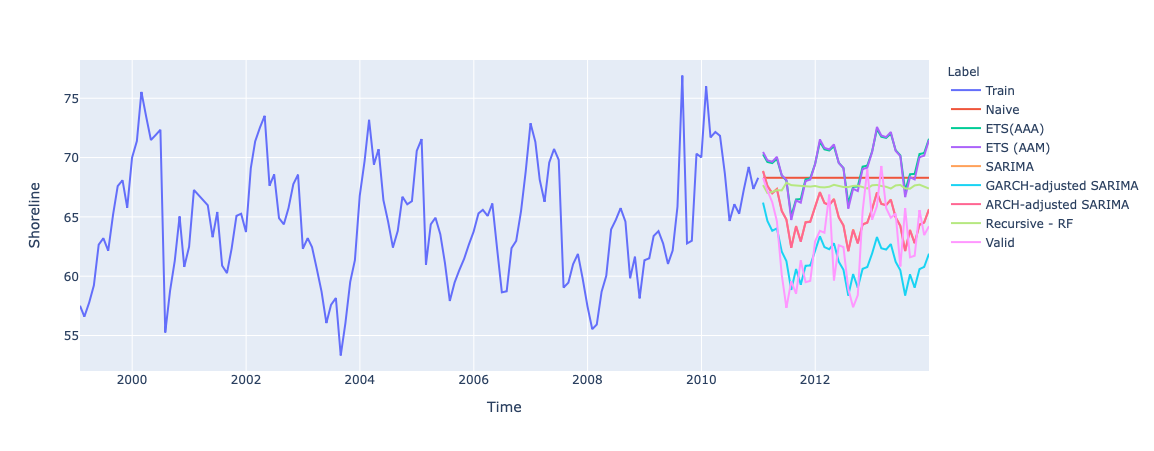

In [36]:
# Plot all forecasts
import plotly.express as px
px.line(pd.concat((df_train[["Shoreline", "Label"]], naive, ets_aaa, ets_aam, sarima_df, garch_v_df, garch_m_df, recursive_rf, df_valid)),
        y="Shoreline",
        color="Label")

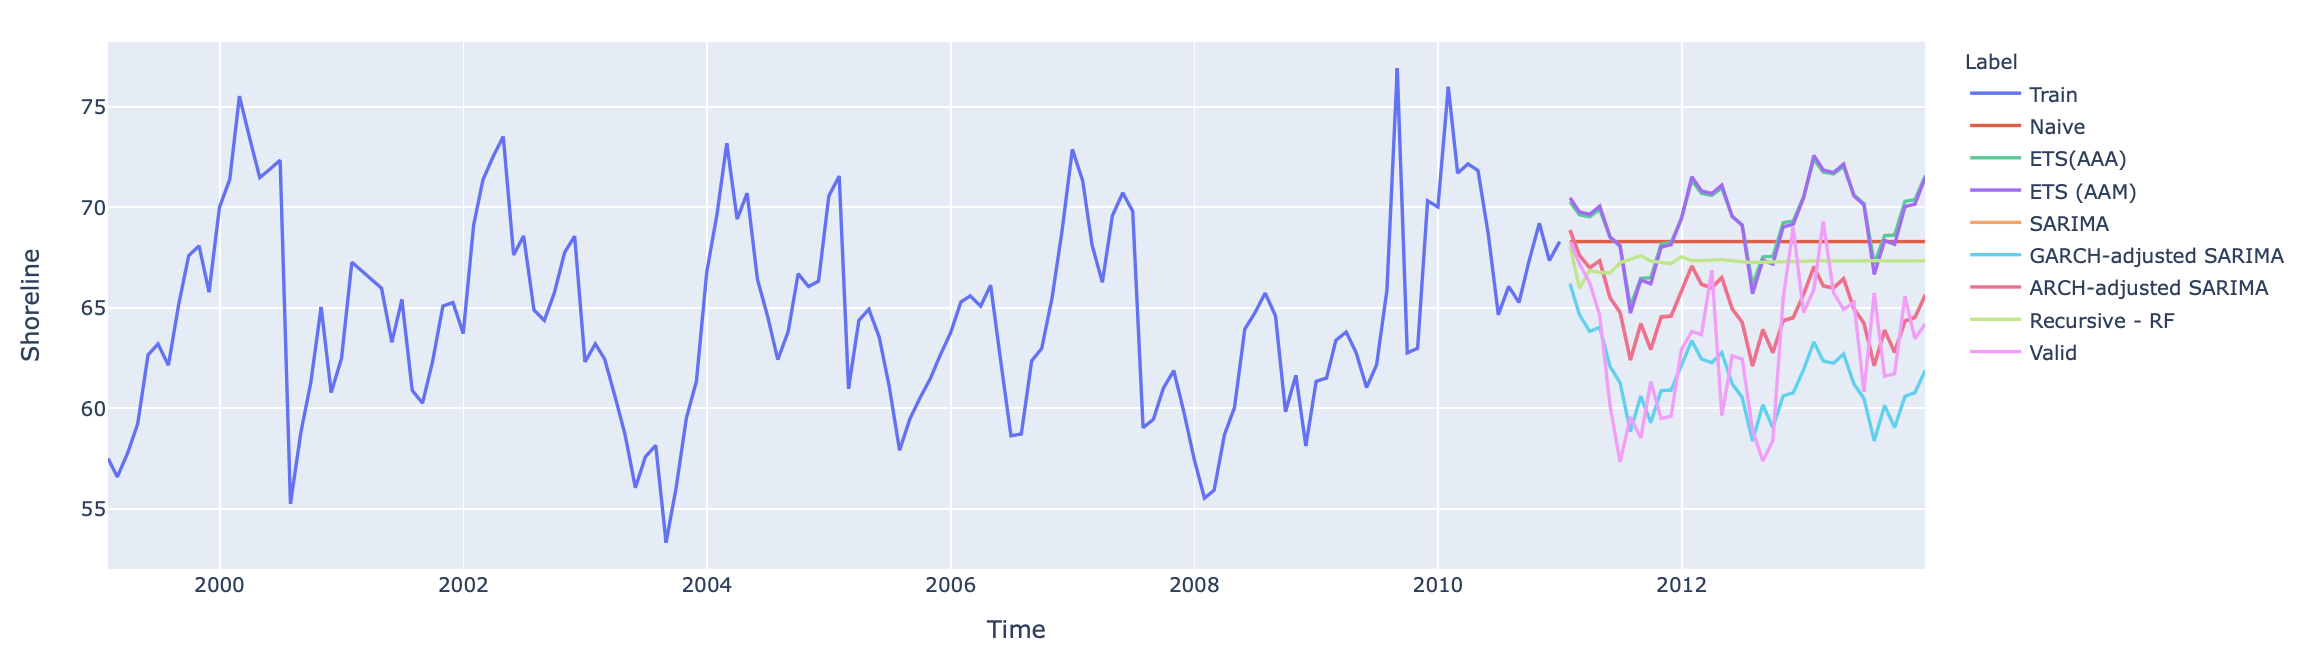

In [37]:
from IPython.display import Image
Image(filename='img/allfx.png')

### Inspect sMAPE and MASE scores

In [38]:
def smape(actual, forecast):
    return 2/len(forecast) * np.sum(np.abs(actual-forecast) / (np.abs(actual) + np.abs(forecast)))

def mase(train, actual, forecast):
    
    n = len(train)
    return (1/len(forecast) * np.sum(np.abs(actual-forecast)) ) / ((1/(n-1)) * np.sum(np.abs(np.diff(train))))

def metric_avg(train, actual, forecast):
    return (0.5 * smape(actual, forecast)) + (0.5 * mase(train, actual, forecast))

In [39]:
results = {}

for model in [naive, ets_aaa, ets_aam, sarima_df, garch_v_df, garch_m_df, recursive_rf]:
    mape = mean_absolute_percentage_error(model.iloc[:,0], df_valid["Shoreline"],)
    smapeval = smape(df_valid["Shoreline"], model.iloc[:,0])
    maseval = mase(df_train["Shoreline"], df_valid["Shoreline"], model.iloc[:,0])
    score = metric_avg(df_train["Shoreline"], df_valid["Shoreline"], model.iloc[:,0])
    results[f"{model.iloc[1,1]}"] = [mape, smapeval, maseval, score]
    
score_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ["MAPE", "sMAPE", "MASE","AVG(sMAPE, MASE)"])
score_df

MAPE     sMAPE      MASE  AVG(sMAPE, MASE)
Naive                  0.077051  0.081318  2.112379          1.096849
ETS(AAA)               0.090287  0.095360  2.509788          1.302574
ETS (AAM)              0.089270  0.094247  2.480269          1.287258
SARIMA                 0.042658  0.043774  1.108690          0.576232
GARCH-adjusted SARIMA  0.043361  0.042317  1.066881          0.554599
ARCH-adjusted SARIMA   0.042410  0.043507  1.101686          0.572597
Recursive - RF         0.068512  0.072024  1.858479          0.965251

### Best Performing Model - Garch-adjusted SARIMA

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20361.00424789055
Iteration:      2,   Func. Count:     12,   Neg. LLF: 37949126199.25479
Iteration:      3,   Func. Count:     20,   Neg. LLF: 62107.25929882065
Iteration:      4,   Func. Count:     26,   Neg. LLF: 17197886.100259762
Iteration:      5,   Func. Count:     32,   Neg. LLF: 572.9696888364251
Iteration:      6,   Func. Count:     38,   Neg. LLF: 2061.2275292283807
Iteration:      7,   Func. Count:     44,   Neg. LLF: 583.4420212741479
Iteration:      8,   Func. Count:     50,   Neg. LLF: 515.9954247139704
Iteration:      9,   Func. Count:     56,   Neg. LLF: 512.9836129467354
Iteration:     10,   Func. Count:     62,   Neg. LLF: 512.1868395208488
Iteration:     11,   Func. Count:     67,   Neg. LLF: 512.1834145599723
Iteration:     12,   Func. Count:     72,   Neg. LLF: 512.1829720220773
Iteration:     13,   Func. Count:     77,   Neg. LLF: 512.1829268377127
Iteration:     14,   Func. Count:     81,   Neg. LLF: 512.1829

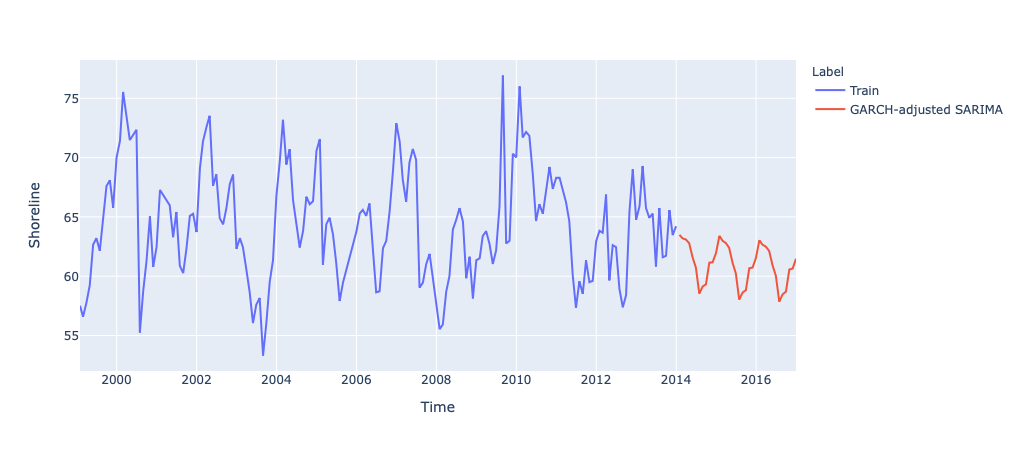

In [40]:
# Load data
train_df = pd.read_csv('data/beach-train.csv', parse_dates=True, index_col='Time').resample("1M").mean().interpolate(method="linear")
test_df = pd.read_csv('data/beach-test.csv', parse_dates=True, index_col='Time')  
train_df.index.freq = "M"
test_df.index.freq = "M"
train_df.head()

# Develop model
sarima = ARIMA(train_df["Shoreline"], order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)).fit()
garch = arch_model(sarima.resid, p=1, q=1)
garch_fitted = garch.fit();

# Make predictions

forecast_index = create_forecast_index(train_df.index[-1], 36)
sarima_forecast = pd.DataFrame({"Shoreline": sarima.forecast(len(test_df)),
                         "Label": "SARIMA"},
                        index=forecast_index)

garch_forecast = garch_fitted.forecast(horizon=len(test_df), reindex=True)
garch_forecasts = pd.DataFrame({"GARCH Forescasts Variance": np.array(garch_forecast.variance.iloc[-1])},
                        index=forecast_index)
garch_forecasts['Shoreline'] = sarima_forecast['Shoreline'] - np.sqrt(garch_forecasts['GARCH Forescasts Variance'])
garch_forecasts['Label'] = 'GARCH-adjusted SARIMA'
garch_forecasts = garch_forecasts.drop(columns=["GARCH Forescasts Variance"])

# Make plot
train_df['Label'] = "Train"
px.line(pd.concat((train_df[["Shoreline", "Label"]], garch_forecasts)),
        y="Shoreline",
        color="Label")

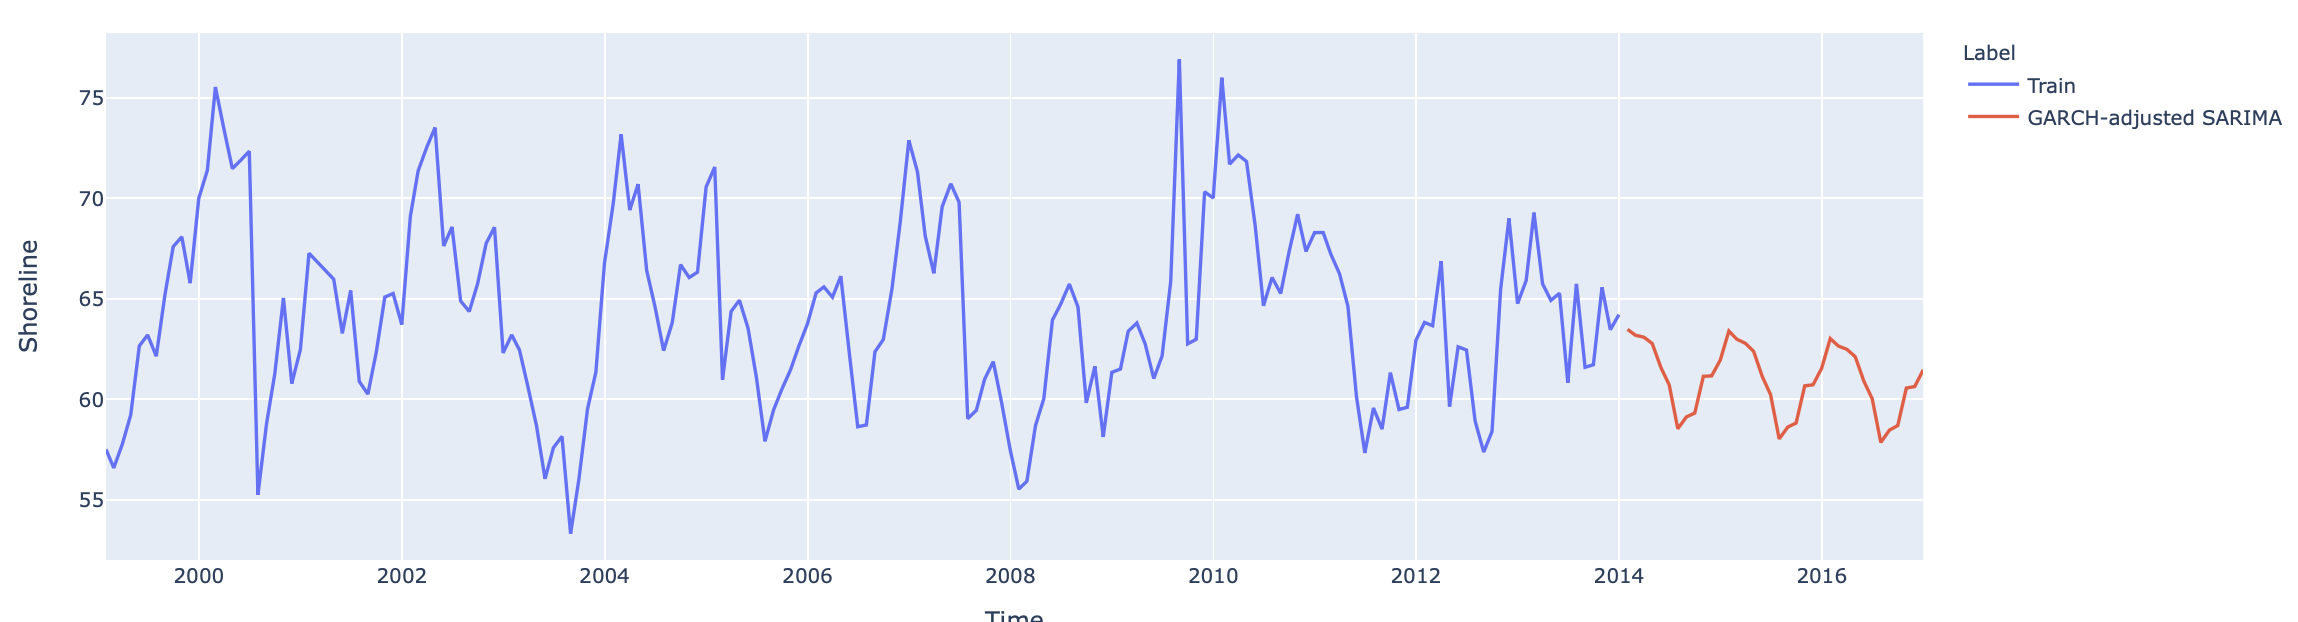

In [41]:
from IPython.display import Image
Image(filename='img/final_fx.png')

In [42]:
# Export prediction to beach-test.csv
test_df["Shoreline"] = np.array(garch_forecasts['Shoreline'])
test_df.to_csv("data/beach-test-lara.csv") # save file as CSV

## Submit to Canvas and GitHub
<hr>

**Be sure to push your predictions .csv file to GitHub so I can evaluate it**. You should also submit a HTML-render of your assignment to Canvas as-per-usual so we can look at your code and plot (you do not need to submit your .csv predictions to Canvas).

When you are ready to submit your assignment do the following:
1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Run All Cells...`
2. Save your notebook.
3. Convert your notebook to `.html` format using the `convert_notebook()` function below or by `File -> Export Notebook As... -> Export Notebook to HTML`
4. Run the code `submit()` below to go through an interactive submission process to Canvas.
5. Finally, push all your work to GitHub (including the rendered html file).

In [43]:
# convert_notebook("lab3.ipynb", "html")  # save your notebook, then uncomment and run when you want to convert to html

In [44]:
# submit(course_code=59092)  # uncomment and run when ready to submit to Canvas

In [45]:
def mase(y_test, y_pred, y_train):
    """Mean absolute scaled error.

    Parameters
    ----------
    y_test : array_like
        True observations for forecast period.
    y_pred : array_like
        Forecasts.
    y_train : array_like
        Training observations.
        
    Returns
    -------
    loss : float
        MASE loss.
        
    References
    ----------
    ..[1]   Hyndman, R. J. (2006). "Another look at measures of forecast
            accuracy", Foresight, Issue 4.
    """
    # Coerce to array
    y_test = np.array(y_test).squeeze()
    y_pred = np.array(y_pred).squeeze()
    y_train = np.array(y_train).squeeze()
    # MASE
    y_pred_naive = y_train[:-1]  #  naive forecasts on training data
    mae_naive = np.mean(np.abs(y_train[1:] - y_pred_naive))  # MAE of naive forecasts
    return np.mean(np.abs(y_test - y_pred)) / mae_naive

def smape(y_test, y_pred):
    """Symmetric mean absolute percentage error
    
    Parameters
    ----------
    y_test : array_like
        True observations for forecast period.
    y_pred : array_like
        Forecasts.
        
    Returns
    -------
    loss : float
        sMAPE loss.
        
    References
    ----------
    ..[1]   Hyndman, R. J. (2006). "Another look at measures of forecast
            accuracy", Foresight, Issue 4.
    """
    # Coerce to array
    y_test = np.array(y_test).squeeze()
    y_pred = np.array(y_pred).squeeze()
    # sMAPE
    numerator = np.abs(y_test - y_pred)
    denominator = np.abs(y_test) + np.abs(y_pred)
    return np.mean(2.0 * numerator / denominator)

In [55]:
results = {}

for model in [naive, ets_aaa, ets_aam, sarima_df, garch_v_df, garch_m_df, recursive_rf]:
    smapeval = smape(df_valid["Shoreline"], model.iloc[:,0])
    maseval = mase(df_valid["Shoreline"], model.iloc[:,0], df_train["Shoreline"])
    mase_loss = maseval / y_naive_mase
    smape_loss = smapeval / y_naive_smape
    score = np.mean((mase_loss, smape_loss))
    results[f"{model.iloc[1,1]}"] = [smapeval, maseval, score]
    
score_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ["sMAPE", "MASE", "SCORE"])
score_df

sMAPE      MASE     SCORE
Naive                  0.081318  2.112379  1.000000
ETS(AAA)               0.095360  2.509788  1.180410
ETS (AAM)              0.094247  2.480269  1.166577
SARIMA                 0.043774  1.108690  0.531580
GARCH-adjusted SARIMA  0.042317  1.066881  0.512723
ARCH-adjusted SARIMA   0.043507  1.101686  0.528280
Recursive - RF         0.072024  1.858479  0.882756

In [54]:
naive.iloc[:,0]

    mase_loss = mase(y_test, y_pred, y_train) / y_naive_mase
    smape_loss = smape(y_test, y_pred) / y_naive_smape
    scores.append(np.mean((mase_loss, smape_loss)))

# Naive forecasts (will be used to scale metrics)
y_naive = np.full_like(df_valid["Shoreline"], df_train["Shoreline"].iloc[-1])
y_naive_mase = mase(df_valid["Shoreline"], y_naive, df_train["Shoreline"])
y_naive_smape = smape(df_valid["Shoreline"], y_naive)

In [52]:
y_naive

array([68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525, 68.2947525, 68.2947525, 68.2947525, 68.2947525,
       68.2947525])

In [48]:
df_valid["Shoreline"]

Time
2011-01-31    68.296400
2011-02-28    67.206214
2011-03-31    66.238548
2011-04-30    64.632781
2011-05-31    60.124200
2011-06-30    57.335750
2011-07-31    59.569333
2011-08-31    58.520400
2011-09-30    61.327182
2011-10-31    59.493105
2011-11-30    59.604500
2011-12-31    62.934941
2012-01-31    63.825964
2012-02-29    63.661833
2012-03-31    66.875964
2012-04-30    59.644941
2012-05-31    62.613344
2012-06-30    62.452917
2012-07-31    58.931075
2012-08-31    57.379050
2012-09-30    58.400750
2012-10-31    65.474917
2012-11-30    68.999500
2012-12-31    64.762491
2013-01-31    65.911382
2013-02-28    69.287750
2013-03-31    65.746077
2013-04-30    64.921529
2013-05-31    65.276967
2013-06-30    60.822692
2013-07-31    65.742235
2013-08-31    61.593417
2013-09-30    61.720667
2013-10-31    65.567900
2013-11-30    63.464389
2013-12-31    64.210750
Freq: M, Name: Shoreline, dtype: float64